# trigram language model

In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))

In [4]:
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
# train a trigram

# create data
xs = []
ys = []
for w in words:
  ch = '.' + w + '.'
  for ch1, ch2, ch3 in zip(ch, ch[1:], ch[2:]):
    # print(ch1,ch2,ch3)
    xs.append([stoi[ch1],stoi[ch2]])
    ys.append(stoi[ch3])

xs = torch.tensor(xs)
ys = torch.tensor(ys)


In [6]:
xenc = F.one_hot(xs, 27).float()

In [7]:
# xenc.shape

torch.Size([196113, 2, 27])

In [8]:
# xenc[:1].reshape(-1,2*27)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
xenc = xenc.view(-1,2*27)

In [10]:
# xenc.shape

torch.Size([196113, 54])

In [11]:
num = len(xs)
num

196113

In [12]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54,27),requires_grad=True, generator= g)

In [13]:
# forward
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1,keepdim=True) # Normalize
loss = -probs[torch.arange(num),ys].log().mean() # negative mean log likelihood
loss

tensor(4.1863, grad_fn=<NegBackward0>)

In [14]:
# backward
W.grad = None
loss.backward()

In [15]:
# update
W.data -= 50*W.grad

In [84]:
for k in range(100):
  logits = xenc @ W
  counts = logits.exp()
  probs = counts / counts.sum(1,keepdim=True) # Normalize
  loss = -probs[torch.arange(num),ys].log().mean() # negative mean log likelihood
  W.grad = None
  loss.backward()
  W.data -= 10*W.grad
  if k%10 == 0: print(loss.item())

2.2410173416137695
2.2409908771514893
2.2409651279449463
2.2409396171569824
2.2409143447875977
2.240889310836792
2.2408642768859863
2.240839719772339
2.2408156394958496
2.2407915592193604


In [98]:
for i in range(5):

  ix0 = 0
  ix1 = torch.randint(low = 1,high=27,size=(1,),generator=g).item()

  out = []
  out.append(itos[ix1])
  while True:
    xenc = F.one_hot(torch.tensor([ix0,ix1]), 27).float()
    xenc = xenc.view(-1,2*27)
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(1,keepdim=True)
    ix2 = torch.multinomial(p,1,replacement=True,generator=g).item()
    out.append(itos[ix2])
    # print(itos[ix0],itos[ix1],itos[ix2])
    if ix2 == 0:
      break
    ix0 = ix1
    ix1 = ix2
  print(''.join(out))

rialiyphrgha.
nazra.
olia.
aydheelvan.
pha.


In [97]:
# counting

N = torch.zeros((27,27,27), dtype=torch.int32)

for w in words:
  ch = '.' + w + '.'
  for ch1,ch2,ch3 in zip(ch,ch[1:],ch[2:]):
    # print(ch1,ch2,ch3)
    idx1 = stoi[ch1]
    idx2 = stoi[ch2]
    idx3 = stoi[ch3]
    N[idx1,idx2,idx3] += 1

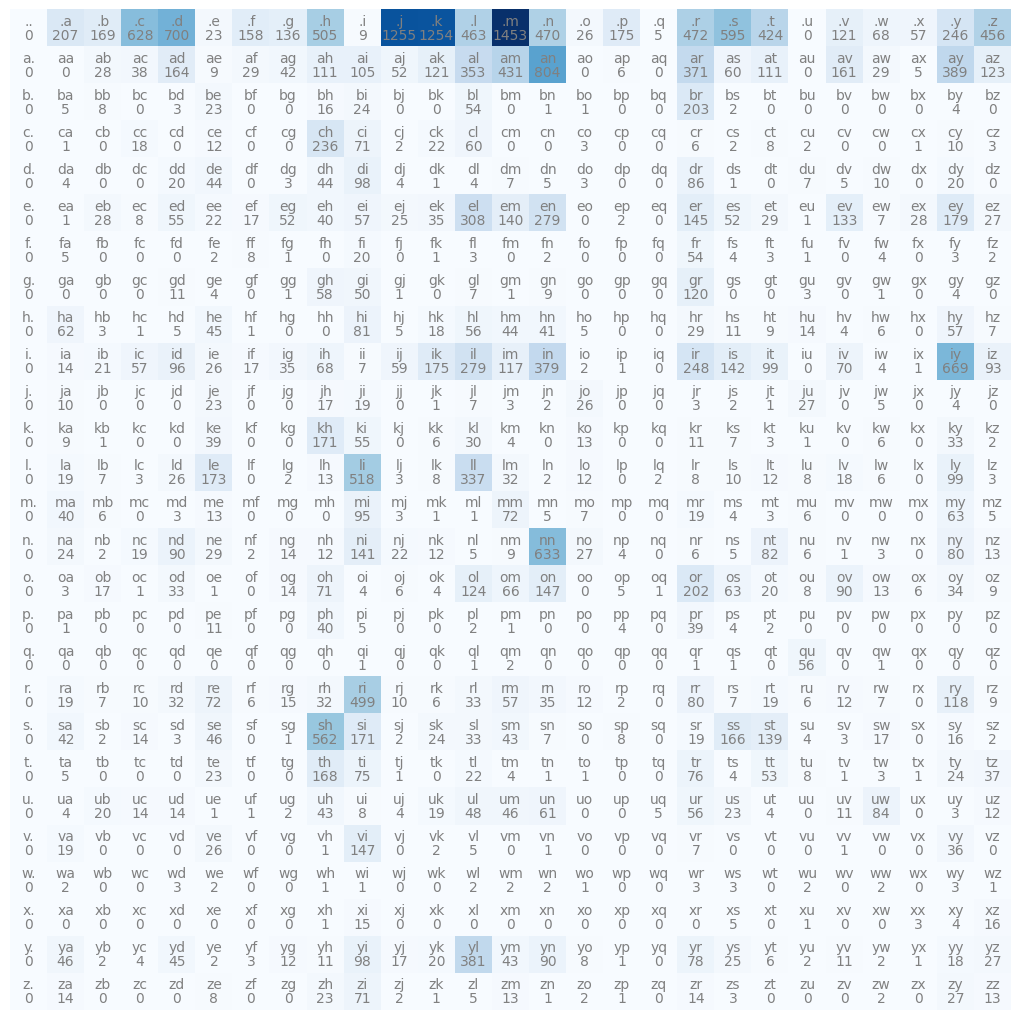

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(13,13))
plt.imshow(N[:,:,1], cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j,1].item(), ha="center", va="top", color='gray')
plt.axis('off'); # 0,1,a

In [45]:
probs = (N+1).float()
probs /= probs.sum(2,keepdim=True)

In [46]:
# N.float().sum(2,keepdim=True).shape

In [48]:
probs[1,1].sum()

tensor(1.0000)

In [59]:
probs.shape

torch.Size([27, 27, 27])

In [49]:
g = torch.Generator().manual_seed(2147483647)

In [50]:
# p = torch.rand(3,generator=g)
# p/=p.sum()
# p

tensor([0.6064, 0.3033, 0.0903])

In [57]:
# torch.multinomial(p,10,replacement=True,generator=g)

tensor([1, 1, 2, 0, 0, 1, 0, 0, 1, 0])

In [70]:
# ix = torch.multinomial(probs[0,1],1,replacement=True,generator=g).item()
# itos[ix]

'd'

In [76]:
for i in range(5):

  ix0 = 0
  ix1 = torch.randint(low = 1,high=27,size=(1,),generator=g).item()
  out = []
  out.append(itos[ix1])
  while True:
    p = probs[ix0,ix1]
    ix2 = torch.multinomial(p,1,replacement=True,generator=g).item()
    out.append(itos[ix2])
    # print(itos[ix0],itos[ix1],itos[ix2])
    if ix2 == 0:
      break
    ix0 = ix1
    ix1 = ix2
  print(''.join(out))

barcera.
na.
rohna.
xita.
kalyn.


In [77]:
log_likelihood = 0.0
n =0
for w in words:
  ch = '.'+w+'.'
  for ch1,ch2,ch3 in zip(ch,ch[1:],ch[2:]):
    idx1 = stoi[ch1]
    idx2 = stoi[ch2]
    idx3 = stoi[ch3]
    p = probs[idx1,idx2,idx3]
    log_likelihood += torch.log(p)
    n += 1
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'average negative log likelihood = {nll/n}')

log_likelihood=tensor(-410414.9688)
nll=tensor(410414.9688)
average negative log likelihood = 2.092747449874878
